# Scale-Free Networks

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import matplotlib.pyplot as plt

import random
import networkx as nx
import numpy as np

import thinkplot

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(18)

## Graphs

To represent social networks, we'll use `nx.Graph`, the graph representation provided by NetworkX.

Each person is represented by a node.  Each friendship is represented by an edge between two nodes.

Here's a simple example with 4 people:

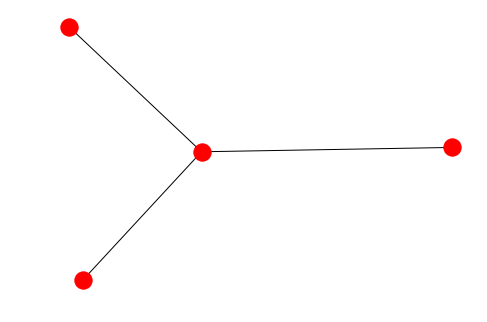

In [3]:
G = nx.Graph()
G.add_edge(1, 0)
G.add_edge(2, 0)
G.add_edge(3, 0)
nx.draw(G)

The number of friends a person has is the number of edges that connect to their node, which is the "degree" of the node.

In [4]:
for node in G.nodes():
    print(node, G.degree(node))

1 1
0 3
2 1
3 1


We are often intereted in the "degree distribution" of a graph, which is the number of people who have 0 friends, the number who have 1 friend, and so on.

The following function extracts a list of degrees, one for each node in a graph.

In [5]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(node) for node in G]

Here's the result for the small example.

In [6]:
degrees(G)

[1, 3, 1, 1]

I'll use `Pmf` from `thinkstats2` to make a probability mass function.

In [7]:
from thinkstats2 import Pmf

pmf = Pmf(degrees(G))
pmf

Pmf({1: 0.75, 3: 0.25})

And `thinkplot` to display it.

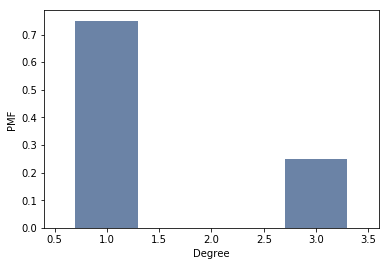

In [8]:
thinkplot.Hist(pmf, width=0.6)
thinkplot.Config(xlabel='Degree', ylabel='PMF', xlim=[0.4, 3.6])

**Exercise:** Add another node or nodes to the graph above, and add a few edges.  Plot the new degree distribution.

## Facebook data

The following function reads a file with one edge per line, specified by two integer node IDs.

In [9]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

We'll read the Facecook data downloaded from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html)

In [10]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

To see how popular "you" are, on average, we'll draw a random sample of 1000 people.

In [11]:
sample = np.random.choice(fb.nodes(), 1000, replace=True)

For each "you" in the sample, we'll look up the number of friends.

In [12]:
num_your_friends = [fb.degree(node) for node in sample]

To plot the degree distribution, I'll use `EstimatedPdf`, which computes a smooth Probability Density Function that fits the data.

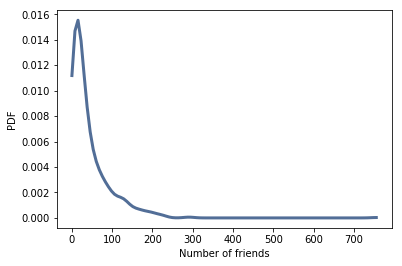

In [13]:
from thinkstats2 import EstimatedPdf

you_pdf = EstimatedPdf(num_your_friends)
thinkplot.Pdf(you_pdf)
thinkplot.Config(xlabel='Number of friends', ylabel='PDF')

Now what if, instead of "you", we choose one of your friends, and look up the number of friends your friend has.

In [14]:
num_friends_friends = []
for node in sample:
    friends = list(fb.neighbors(node))
    friend = np.random.choice(friends)
    num_friends_friends.append(fb.degree(friend))

Here's the degree distribution for your friend's friends:

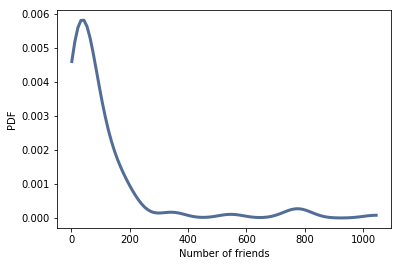

In [15]:
friends_pdf = EstimatedPdf(num_friends_friends)
thinkplot.Pdf(friends_pdf)
thinkplot.Config(xlabel='Number of friends', ylabel='PDF')

The bulk of the distribution is wider, and the tail is thicker.  This difference is reflected in the means:

In [16]:
np.mean(num_your_friends), np.mean(num_friends_friends)

(43.158, 105.745)

And we can estimate the probability that your friend has more friends than you.

In [17]:
np.mean([friend > you for you, friend in zip(num_your_friends, num_friends_friends)])

0.68

## Power law distributions

As we'll see below, the degree distribution in the Facebook data looks, in some ways, like a power law distribution.  To see what that means, we'll look at the Zipf distribution, which has a power law tail.

Here's a sample from a Zipf distribution.

In [18]:
zipf_sample = np.random.zipf(a=2, size=10000)

Here's what the PMF looks like.

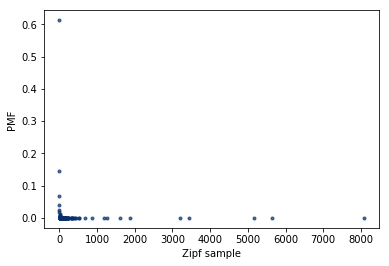

In [19]:
pmf = Pmf(zipf_sample)
thinkplot.Pdf(pmf, style='.')
thinkplot.Config(xlabel='Zipf sample', ylabel='PMF')

Here it is on a log-x scale.

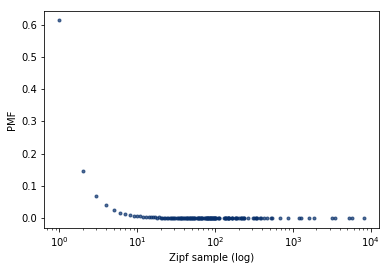

In [20]:
thinkplot.Pdf(pmf, style='.')
thinkplot.Config(xlabel='Zipf sample (log)', ylabel='PMF', xscale='log')

And on a log-log scale.

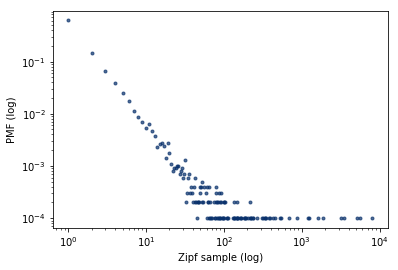

In [21]:
thinkplot.Pdf(pmf, style='.')
thinkplot.Config(xlabel='Zipf sample (log)', ylabel='PMF (log)', 
                 xscale='log', yscale='log')

On a log-log scale, the PMF of the Zipf distribution looks like a straight line (until you get to the extreme tail, which is discrete and noisy.

In [22]:
mu, sigma = zipf_sample.mean(), zipf_sample.std()
mu, sigma

(7.5801, 126.11134121874207)

For comparison, let's look at the Poisson distribution, which does not have a power law tail.  I'll choose the Poisson distribution with the same mean as the sample from the Zipf distribution.

In [23]:
poisson_sample = np.random.poisson(lam=mu, size=10000)
poisson_sample.mean(), poisson_sample.std()

(7.6425, 2.7605966293538793)

Here's the PMF on a log-log scale.  It is definitely not a straight line.

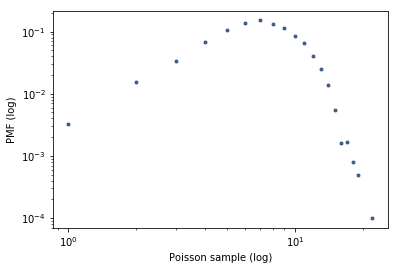

In [24]:
poisson_pmf = Pmf(poisson_sample)
thinkplot.Pdf(poisson_pmf, style='.')
thinkplot.Config(xlabel='Poisson sample (log)', ylabel='PMF (log)', 
                 xscale='log', yscale='log')

So this gives us a simple way to test for power law behavior.  If you plot the PMF on a log-log scale, and the result is a straight line, they is evidence of power law behavior.

This test is not entirely reliable; there are better options.  But it's good enough for an initial exploration.

## Barabási and Albert

Let's see what the degree distribution for the Facebook data looks like on a log-log scale.

In [25]:
pmf_fb = Pmf(degrees(fb))

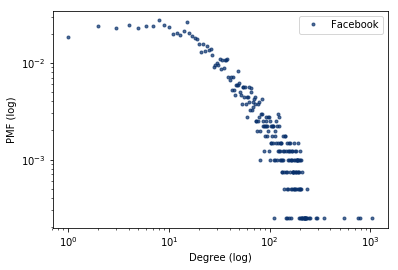

In [26]:
thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xscale='log', yscale='log', loc='upper right',
                 xlabel='Degree (log)', ylabel='PMF (log)')

For degrees greater than 10, it resembles the Zipf sample (and doesn't look much like the Poisson sample).

We can estimate the parameter of the Zipf distribution by eyeballing the slope of the tail.

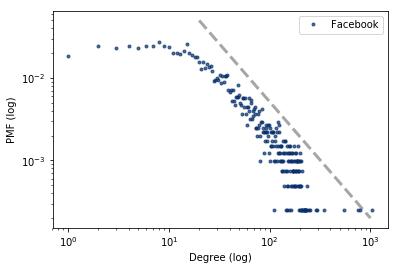

In [27]:
thinkplot.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')

thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xscale='log', yscale='log', loc='upper right',
                 xlabel='Degree (log)', ylabel='PMF (log)')

Here's a simplified version of the NetworkX function that generates BA graphs.

In [28]:
# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py

def barabasi_albert_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

And here's the function that generates a random subset without repetition.

In [29]:
def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

I'll generate a BA graph with the same number of nodes and edges as the Facebook data:

In [30]:
n = len(fb)
m = len(fb.edges())
k = int(round(m/n))
n, m, k

(4039, 88234, 22)

Providing a random seed means we'll get the same graph every time.

In [31]:
ba = barabasi_albert_graph(n, k, seed=15)

The number of edges is pretty close to what we asked for.

In [32]:
len(ba), len(ba.edges()), len(ba.edges())/len(ba)

(4039, 88374, 21.88016835850458)

So the mean degree is about right.

In [33]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

The standard deviation of degree is pretty close; maybe a little low.

In [34]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 41.15058490188548)

Let's take a look at the degree distribution.

In [35]:
pmf_ba = Pmf(degrees(ba))

Looking at the PMFs on a linear scale, we see one difference, which is that the BA model has no nodes with degree less than `k`, which is 22.

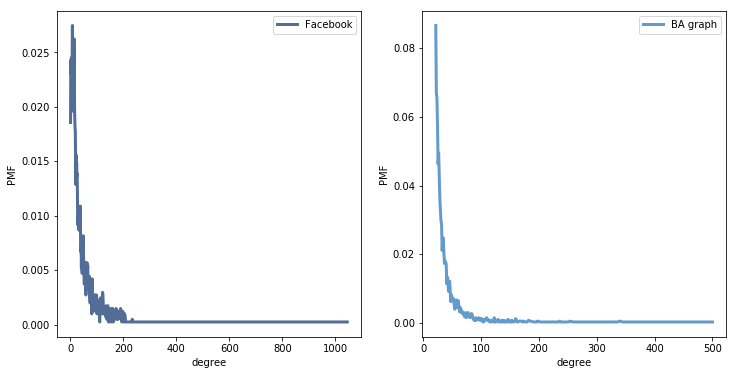

In [36]:
thinkplot.preplot(cols=2)

thinkplot.Pdf(pmf_fb, label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ba, label='BA graph')
thinkplot.config(xlabel='degree', ylabel='PMF')

If we look at the PMF on a log-log scale, the BA model looks pretty good for values bigger than about 20.  And it seems to follow a power law.

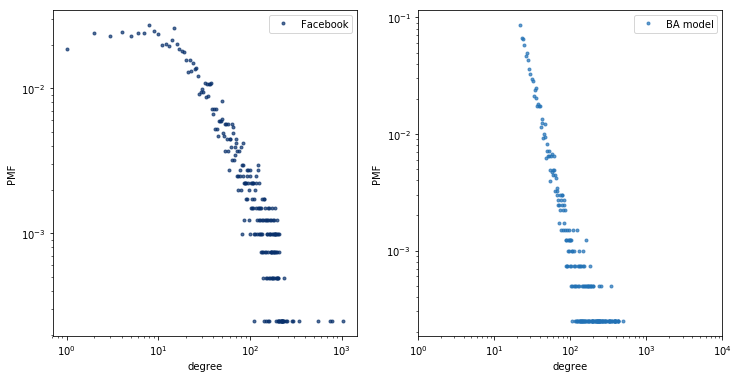

In [37]:
thinkplot.preplot(cols=2)

thinkplot.Pdf(pmf_fb, style='.', label='Facebook')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xscale='log', yscale='log')

thinkplot.subplot(2)

thinkplot.Pdf(pmf_ba, style='.', label='BA model')
thinkplot.config(xlabel='degree', ylabel='PMF')
thinkplot.config(xlim=[1, 1e4],
                 xscale='log', yscale='log')

## Cumulative distributions

Cumulative distributions are a better way to visualize distributions.  The following function shows what a cumulative probability is:

In [38]:
def cumulative_prob(pmf, x):
    """Computes the cumulative probability of `x`.
    
    Total probability of all values <= x.
    
    returns: float probability
    """
    ps = [pmf[value] for value in pmf if value<=x]
    return sum(ps)

The total probability for all values up to and including 11 is 0.258, so the 25th percentile is about 11.

In [39]:
cumulative_prob(pmf_fb, 11)

0.2577370636296113

The median degree is about 25.

In [40]:
cumulative_prob(pmf_fb, 25)

0.5060658578856153

And the 75th percentile is about 57.  That is, about 75% of users have 57 friends or fewer.

In [41]:
cumulative_prob(pmf_fb, 57)

0.751671205743996

`thinkstats2` provides `Cdf`, which computes cumulative distribution functions.

In [42]:
from thinkstats2 import Cdf

Here are the degree CDFs for the Facebook data, the WS model, and the BA model.

In [43]:
cdf_fb = Cdf(degrees(fb), label='Facebook')

In [44]:
cdf_ba = Cdf(degrees(ba), label='BA model')

If we plot them on a log-x scale, we get a sense of how well the models fit the central part of the distribution.

The BA model is ok for values above the median, but not very good for smaller values.

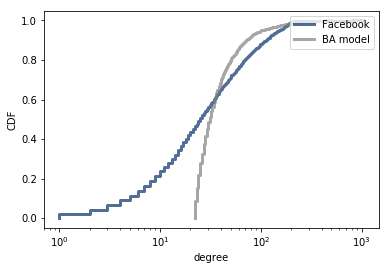

In [45]:
thinkplot.Cdf(cdf_fb, label='Facebook')
thinkplot.Cdf(cdf_ba, color='gray')
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CDF')

On a log-log scale, we see that the BA model fits the tail of the distribution reasonably well.

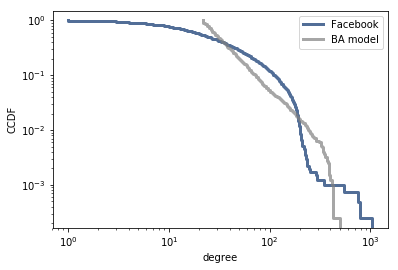

In [46]:
thinkplot.Cdf(cdf_fb, label='Facebook', complement=True)
thinkplot.Cdf(cdf_ba, color='gray', complement=True)
thinkplot.config(xlabel='degree', xscale='log',
                 ylabel='CCDF', yscale='log')

But there is certainly room for a model that does a better job of fitting the whole distribution.